# <a id="contents"></a> Table of Contents

1. [Import Libraries](#imports)
2. [Standardizing Data](#standardizing-data)
3. [Loading Position Data](#loading-data)
4. [Descriptive Statistics and Visualization](#descriptive-stats)
   - 4.1 [Descriptive Statistics Calculation](#descriptive-stats-calc)
   - 4.2 [Displaying Descriptive Statistics as Heatmap](#descriptive-stats-heatmap)
5. [Distribution and Box Plot Visualization](#distribution-and-box-plot)
6. [Correlation Heatmaps](#correlation-heatmaps)
7. [Baseline Models](#baseline-models)
   - 7.1 [Defense PCA Baseline](#baseline-models-defense)
   - 7.2 [Midfielder PCA Baseline](#baseline-models-midfielder)
   - 7.3 [Goalkeeper PCA Baseline](#baseline-models-goalkeeper)
   - 7.4 [Goalkeeper PCA Baseline](#baseline-models-goalkeeper)


<a id="imports"></a>

## <div class='section'>Section 1: Import Libraries</div>


In [130]:
import itertools
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="standardizing-data"></a>

## <div class='section'>Section 2: Standardizing Data</div>

[Return to contents](#contents)

Here, we define a `standardize` function that will be used to scale and standardize the data to ensure that each feature contributes equally to any subsequent analysis so that we can avoid biases due to differences in scale.


In [131]:
def standardize(df):
    
    if 'Player' in df.columns:
        player_column = df['Player']
        
    numeric_columns = df.select_dtypes(include='number').columns
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df[numeric_columns])

    standardized_df = pd.DataFrame(standardized_data, columns=numeric_columns)
    standardized_df['Player'] = player_column.reset_index(drop=True)
    
    return standardized_df


<a id="loading-data"></a>

## <div class='section'>Section 3: Loading Position Data</div>

[Return to contents](#contents)

Here, we load and `standardize` data from CSV files for each position, then organize them in a dictionary.


In [132]:
# Make dataframes
goalkeepers = standardize(pd.read_csv("stats/GK_relevant_stats.csv"))
defenders = standardize(pd.read_csv("stats/DF_relevant_stats.csv"))
midfielders = standardize(pd.read_csv("stats/MF_relevant_stats.csv"))
forwards = standardize(pd.read_csv("stats/FW_relevant_stats.csv"))

# Dictionary of dataframes for each position
dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}

<a id="descriptive-stats"></a>

## <div class='section'>Section 4: Descriptive Statistics and Visualization</div>

[Return to contents](#contents)

Here, we calculate and visualize descriptive statistics for each position dataset which will provide insights into the central tendency, spread, and range of values for each feature in the dataset.


<a id="descriptive-stats-calc"></a>

#### <div class='sub-section'>4.1: Descriptive Statistics Calculation</div>

Here, we calculate the mean, standard deviation, median, min, max, and range of each numeric feature in the dataset.




In [133]:
def descriptive_stats(df):
    numeric_df = df.select_dtypes(include='number')
    stats = numeric_df.describe().T  # Transpose for readability
    stats['median'] = numeric_df.median()  # Add median
    stats['range'] = stats['max'] - stats['min']  # Calculate range
    return stats[['mean', 'std', 'median', 'min', 'max', 'range']]


<a id="descriptive-stats-heatmap"></a>

#### <div class='sub-section'>4.2: Displaying Descriptive Statistics as Heatmap</div>

Here, we create heatmaps to visualize the descriptive statistics for each feature and to help us easily spot outliers, patterns, and distributions across different features.

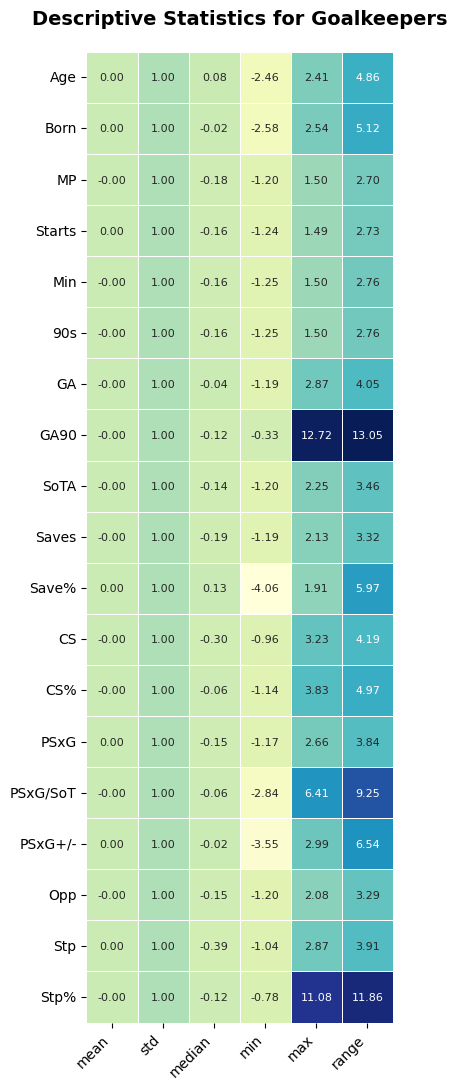

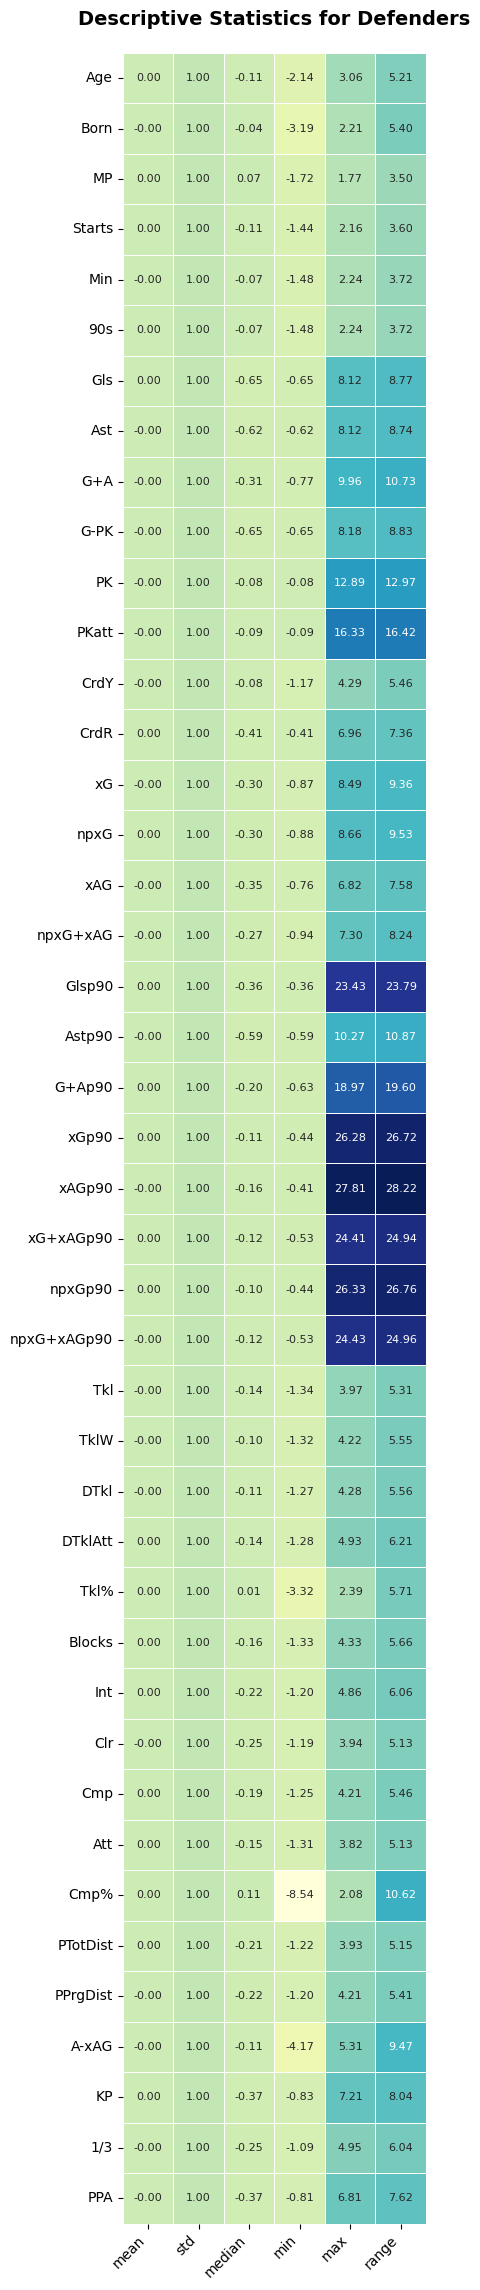

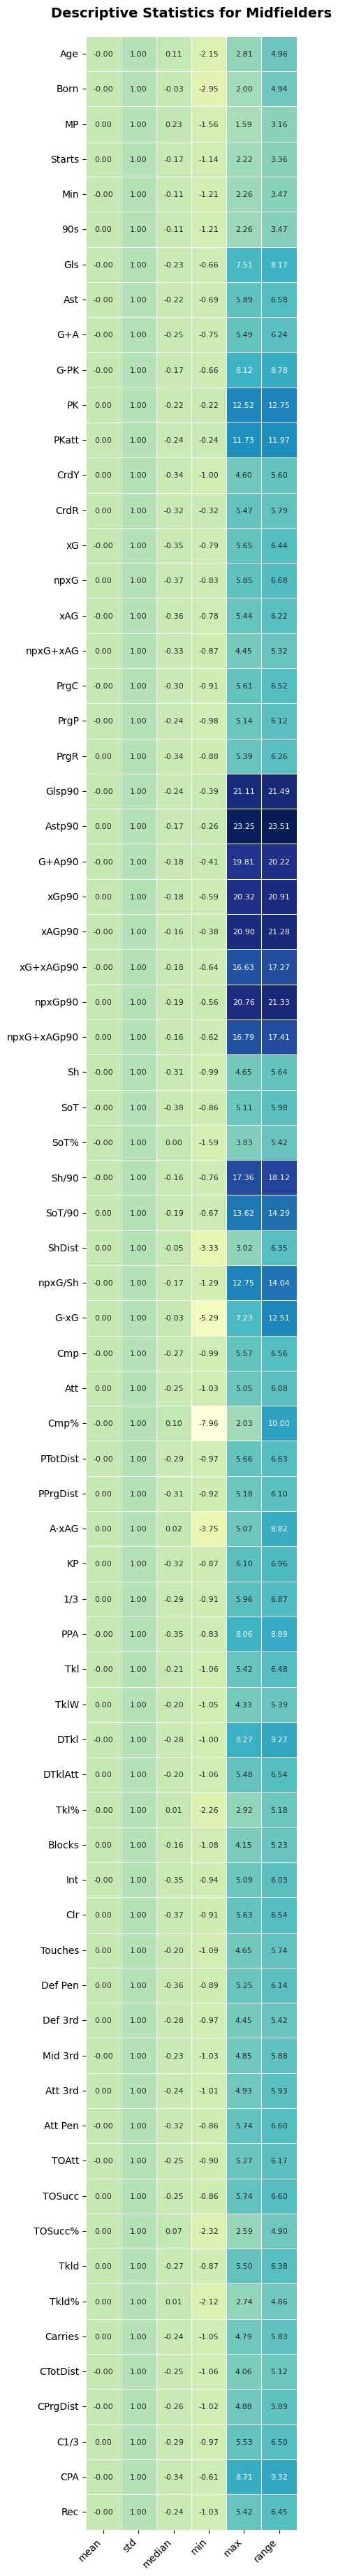

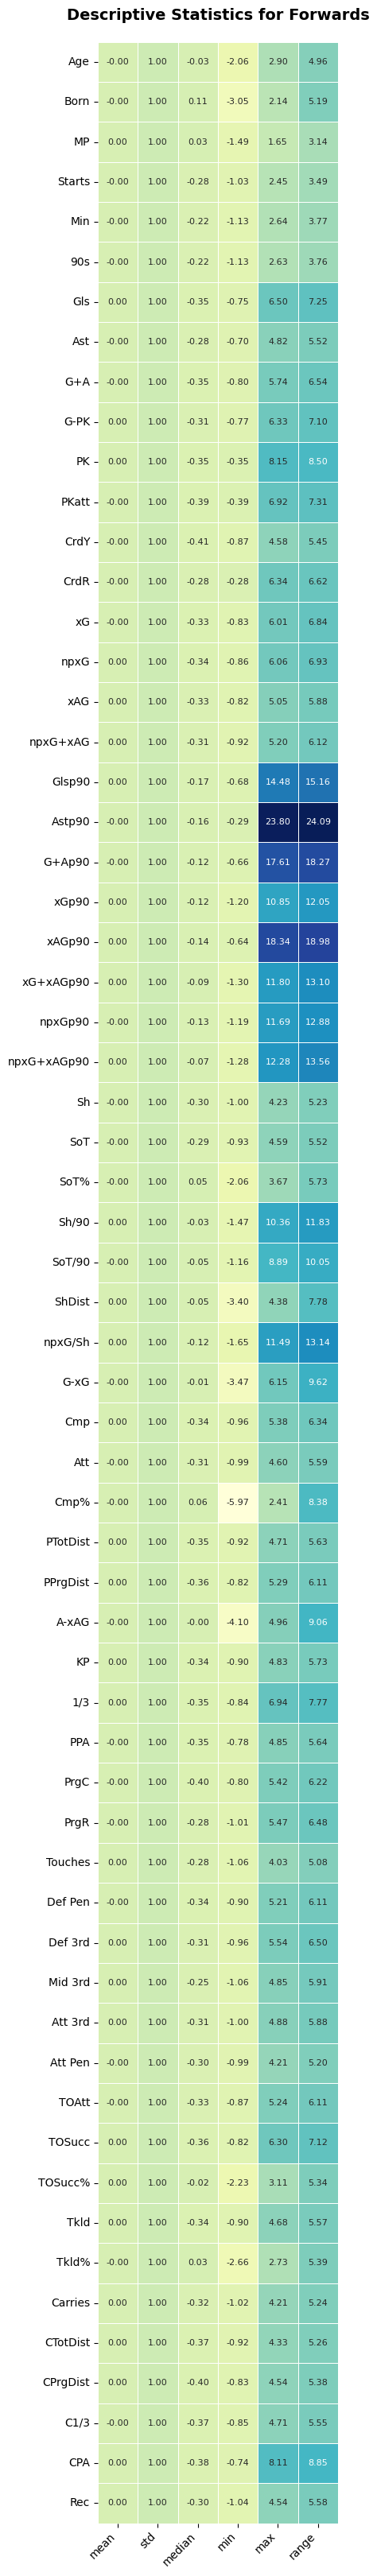

In [134]:
def display_heatmap(stats, title):
    fig, ax = plt.subplots(figsize=(12, len(stats) * 0.5 + 1.5))
    sns.heatmap(stats, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5, 
                annot_kws={"size": 8}, ax=ax, square=True)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title(title, fontweight="bold", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


# generating and displaying heatmap tables for each position's statistics
for position, df in dataframes.items():
    stats = descriptive_stats(df)
    display_heatmap(stats, f"Descriptive Statistics for {position}")


<a id="distribution-and-box-plot-visualization"></a>

## <div class='section'>Section 5: Distribution and Box Plot Visualization</div>

[Return to contents](#contents)

Here, we generate histograms and box plots for each feature to show the distribution and identify potential outliers. The histograms provide insight into how data points are distributed while box plots reveal central tendencies and variability. The histograms and box plots are then saved as PNG files in the 'plots' folder


In [135]:
def plot_and_save_plots(df, position, stats):
    for stat in stats:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        label = stat_labels.get(stat, stat)

        # histogram
        sns.histplot(df[stat].dropna(), kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f'{label} Distribution for {position}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Frequency')

        # boxplot
        sns.boxplot(x=df[stat].dropna(), ax=axes[1], color="lightgreen")
        axes[1].set_title(f'{label} Boxplot for {position}')
        axes[1].set_xlabel(label)

        plt.tight_layout()

        # saving plots
        filename = f"plots/{position}_{stat}_EDA.png".replace(" ", "_")
        plt.savefig(filename, format='png', dpi=300)
        plt.close(fig)

# generating and saving plots for each position
for position, df in dataframes.items():
    print(f"Saving plots for {position}...")
    # plot_and_save_plots(df, position, basic_stats[position])

print("All plots have been saved as PNG files.")


Saving plots for Goalkeepers...
Saving plots for Defenders...
Saving plots for Midfielders...
Saving plots for Forwards...
All plots have been saved as PNG files.


<a id="correlation-heatmaps"></a>

## <div class='section'>Section 6: Correlation Heatmaps</div>

[Return to contents](#contents)

Finally, we create correlation heatmaps to explore any positive or negative relationships between features that may be useful for further analysis or model building.


In [136]:
def save_correlation_heatmap(df, position, stats):
    df_filtered = df[stats]
    corr = df_filtered.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
                linewidths=0.5, annot_kws={"size": 8})
    plt.title(f'Correlation Heatmap for {position}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    filename = f"heatmap/{position}_correlation_heatmap.png".replace(" ", "_")
    plt.savefig(filename, format='png', dpi=300)
    plt.close()

# generating and saving correlation heatmaps for each position
for position, df in dataframes.items():
    print(f"Generating correlation heatmap for {position}...")
    # save_correlation_heatmap(df, position, basic_stats[position])

print("All correlation heatmaps have been saved as PNG files.")


Generating correlation heatmap for Goalkeepers...
Generating correlation heatmap for Defenders...
Generating correlation heatmap for Midfielders...
Generating correlation heatmap for Forwards...
All correlation heatmaps have been saved as PNG files.


<a id="baseline-models"></a>

## <div class='section'>Section 7: Baseline Models</div>

[Return to contents](#contents)

Here we are creating the baseline PCA models for each position.


<a id="baseline-models-defense"></a>

#### <div class='sub-section'>7.1: Defense PCA Baseline</div>


The total number of components is: 43.
The number of components required to explain 95% of the variance is: 15.


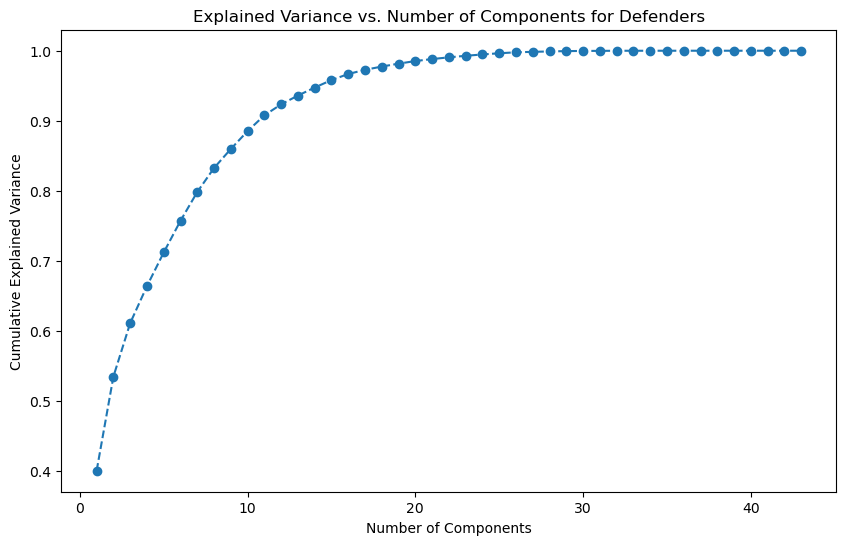

In [137]:
from sklearn.decomposition import PCA

numeric = defenders.select_dtypes(include=[np.number]).dropna()

pca = PCA()
defender_pca= pca.fit_transform(numeric)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Defenders')
plt.show()

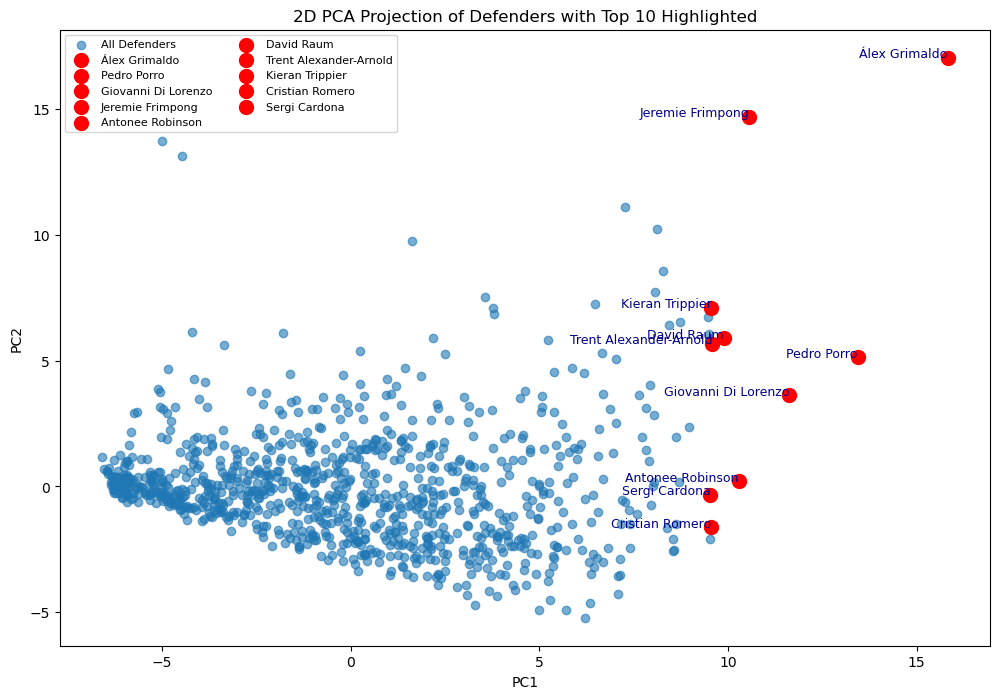

In [138]:
defenders = defenders.loc[numeric.index]
defenders['PC1'] = defender_pca[:, 0]
defenders['PC2'] = defender_pca[:, 1]

top_defenders = defenders.nlargest(10, 'PC1')


plt.figure(figsize=(12, 8))
plt.scatter(defender_pca[:, 0], defender_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_defenders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Defenders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

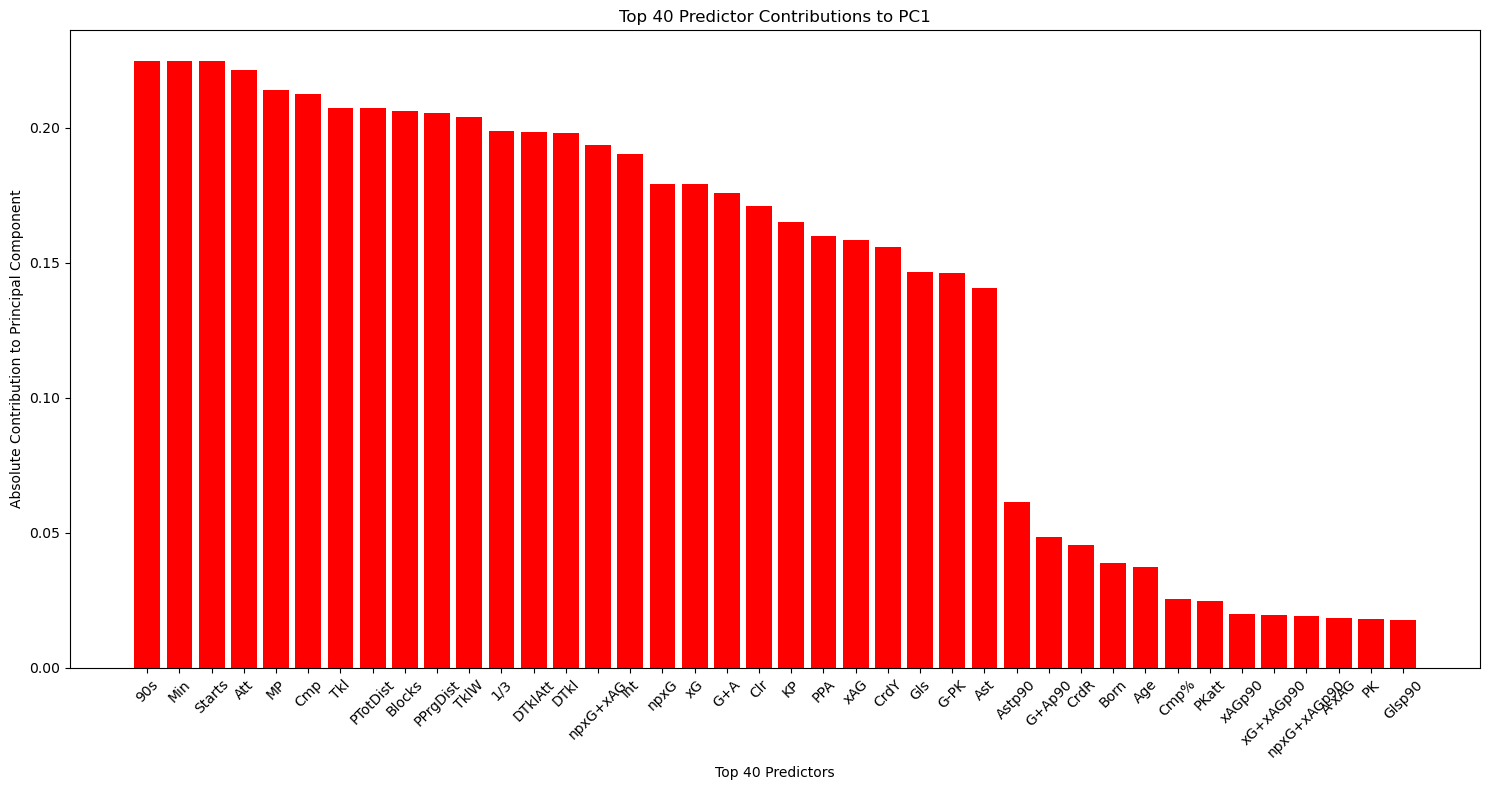

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = numeric.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=45)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

In [140]:
print("Top 10 defenders based on PC1:")
print(top_defenders[['Player', 'PC1', 'PC2']])

Top 10 defenders based on PC1:
                     Player     PC1     PC2
50            Álex Grimaldo  15.817  17.032
796             Pedro Porro  13.435   5.136
354     Giovanni Di Lorenzo  11.628   3.619
435        Jeremie Frimpong  10.555  14.685
89         Antonee Robinson  10.282   0.214
225              David Raum   9.887   5.889
948  Trent Alexander-Arnold   9.582   5.674
536         Kieran Trippier   9.561   7.105
200         Cristian Romero   9.541  -1.628
884           Sergi Cardona   9.531  -0.321



<a id="baseline-models-midfielder"></a>

#### <div class='sub-section'>7.2: Midfielder PCA Baseline</div>


In [141]:
#Reloading datasets (midfielders only contains numeric columns while midfielders_reloaded contains all data)
midfielders = standardize(pd.read_csv("stats/MF_relevant_stats.csv"))
midfielders_reloaded = pd.read_csv('stats/MF_relevant_stats.csv')

# mapping
column_mapping = {
    'MP': 'Matches Played',
    'Starts': 'Starts',
    'Min': 'Minutes Played',
    '90s': '90-Minute Increments',
    'Gls': 'Goals',
    'Ast': 'Assists',
    'G+A': 'Goals + Assists',
    'G-PK': 'Goals (Excl. Penalties)',
    'PK': 'Penalty Goals',
    'PKatt': 'Penalty Attempts',
    'CrdY': 'Yellow Cards',
    'CrdR': 'Red Cards',
    'xG': 'Expected Goals',
    'npxG': 'Non-Penalty Expected Goals',
    'xAG': 'Expected Assists',
    'npxG+xAG': 'Expected Non-Penalty Goals + Assists',
    'PrgC': 'Progressive Carries',
    'PrgP': 'Progressive Passes',
    'PrgR': 'Progressive Runs',
    'Glsp90': 'Goals per 90',
    'Astp90': 'Assists per 90',
    'G+Ap90': 'Goals + Assists per 90',
    'xGp90': 'Expected Goals per 90',
    'xAGp90': 'Expected Assists per 90',
    'xG+xAGp90': 'Expected Goals + Assists per 90',
    'npxGp90': 'Non-Penalty Goals per 90',
    'npxG+xAGp90': 'Non-Penalty Goals + Assists per 90',
    'Sh': 'Shots',
    'SoT': 'Shots on Target',
    'SoT%': 'Shots on Target %',
    'Sh/90': 'Shots per 90',
    'SoT/90': 'Shots on Target per 90',
    'ShDist': 'Average Shot Distance',
    'npxG/Sh': 'Non-Penalty xG per Shot',
    'G-xG': 'Goals Minus xG',
    'Cmp': 'Passes Completed',
    'Att': 'Passes Attempted',
    'Cmp%': 'Pass Completion %',
    'PTotDist': 'Total Passing Distance',
    'PPrgDist': 'Progressive Passing Distance',
    'A-xAG': 'Assists Minus xAG',
    'KP': 'Key Passes',
    '1/3': 'Passes into Final Third',
    'PPA': 'Passes into Penalty Area',
    'Tkl': 'Tackles',
    'TklW': 'Tackles Won',
    'DTkl': 'Dribbles Tackled',
    'DTklAtt': 'Dribbles Tackled Attempts',
    'Tkl%': 'Tackle Success %',
    'Blocks': 'Blocks',
    'Int': 'Interceptions',
    'Clr': 'Clearances',
    'Touches': 'Touches',
    'Def Pen': 'Touches in Defensive Penalty Area',
    'Def 3rd': 'Touches in Defensive Third',
    'Mid 3rd': 'Touches in Midfield Third',
    'Att 3rd': 'Touches in Attacking Third',
    'Att Pen': 'Touches in Attacking Penalty Area',
    'TOAtt': 'Take-On Attempts',
    'TOSucc': 'Take-On Successes',
    'TOSucc%': 'Take-On Success %',
    'Tkld': 'Tackled',
    'Tkld%': 'Tackled %',
    'Carries': 'Carries',
    'CTotDist': 'Total Carry Distance',
    'CPrgDist': 'Progressive Carry Distance',
    'C1/3': 'Carries into Final Third',
    'CPA': 'Carries into Penalty Area',
    'Rec': 'Passes Received'
}

midfielders.rename(columns=column_mapping, inplace=True)

In [142]:
#Dropping NA from both datasets
numeric_columns = midfielders_reloaded.select_dtypes(include=['number']).columns
midfielders_cleaned = midfielders_reloaded.dropna(subset=numeric_columns).copy()
midfielders = midfielders.dropna()

#Fitting the PCA
pca = PCA().fit(midfielders)
pca_mid = pca.transform(midfielders)

#Calculating number of components and CI 
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1 

#Reattaching player names to numeric dataset to ease with analysis
player_column = midfielders_cleaned['Player'].loc[midfielders.index]
midfielders['Player'] = player_column

#Attaching PCA values to dataset
midfielders['PC1'] = pca_mid[:, 0]
midfielders['PC2'] = pca_mid[:, 1]

#Printing findings
print(f"The number of components is: {pca.n_components_}. ")
print(f"The number of components required to explain 95% of the variance is: {n_components_95}")
print("Top 10 midfielders based on PC1:")
print(midfielders[['Player', 'PC1']].sort_values(by='PC1', ascending=False).head(10))

ValueError: could not convert string to float: 'Aaron Ramsey'

In [27]:
# graphing PCA with names
midfielders_reset = midfielders.reset_index(drop=True)
best_midfielders = midfielders.sort_values(by='PC1', ascending=False).head(10)

famous_indices = best_midfielders.index

plt.figure(figsize=(10, 6))
plt.scatter(midfielders['PC1'], midfielders['PC2'], alpha=0.6, label='All Midfielders', edgecolors='k')

for i in famous_indices:
    plt.scatter(midfielders.loc[i, 'PC1'], midfielders.loc[i, 'PC2'], color='red', s=50, label=midfielders.loc[i, 'Player']) 
    plt.text(midfielders.loc[i, 'PC1'], midfielders.loc[i, 'PC2'], midfielders.loc[i, 'Player'], fontsize=9, ha='right', color='darkblue')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Player Data with Highlighted Midfielders")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

In [20]:
#confidence interval
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Midfielders')
plt.legend(loc='lower right')
plt.show()

In [21]:
#Predictor Contributing to Components bar graph
num_components = 2

fig, axes = plt.subplots(num_components, 1, figsize=(15, 15), sharey=True)

for i in range(num_components):
    pc_loadings = pca.components_[i]
    absolute_loadings = np.abs(pc_loadings)  
   
    top_indices = np.argsort(absolute_loadings)[-40:][::-1]  
    top_features = midfielders.columns[top_indices]  
    top_contributions = absolute_loadings[top_indices]  

    axes[i].bar(top_features, top_contributions, color='#FA8072')
    axes[i].set_title(f'Top 40 Predictor Contributions to PC{i + 1}')
    axes[i].set_xticks(range(len(top_features)))
    axes[i].set_xticklabels(top_features, rotation=45, ha='right')
    axes[i].set_xlabel('Top 40 Predictors')
    axes[i].set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="baseline-models-goalkeeper"></a>

#### <div class='sub-section'>7.3: Goalkeeper PCA Baseline</div>

In [22]:
from sklearn.decomposition import PCA

goalkeepers_df = pd.read_csv("stats/GK_relevant_stats.csv")
goalkeepers_numeric = goalkeepers_df.select_dtypes(include=[np.number]).dropna()

pca = PCA()
pca_data = pca.fit_transform(goalkeepers_numeric)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Goalkeepers')
plt.grid()
plt.show()



In [23]:

pca_2d = PCA(n_components=2)
goalkeepers_pca = pca_2d.fit_transform(goalkeepers_numeric)

plt.figure(figsize=(12, 8))
plt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.7, edgecolors='k', s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeeper Data")
plt.grid()
plt.tight_layout()
plt.show()



In [24]:

features = goalkeepers_numeric.columns
pc_loadings = pca_2d.components_
pc1_pc2_loadings = pd.DataFrame(pc_loadings[:2], columns=features, index=['PC1', 'PC2']).T

print("\nTop features contributing to PC1:")
print(pc1_pc2_loadings['PC1'].sort_values(ascending=False).head(5))

print("\nTop features contributing to PC2:")
print(pc1_pc2_loadings['PC2'].sort_values(ascending=False).head(5))



In [25]:

goalkeepers_df = goalkeepers_df.loc[goalkeepers_numeric.index] 
goalkeepers_df['PC1'] = goalkeepers_pca[:, 0]
goalkeepers_df['PC2'] = goalkeepers_pca[:, 1]

# the top 10 goalkeepers based on PC1
top_pc1_goalkeepers = goalkeepers_df[['Player', 'PC1']].sort_values(by='PC1', ascending=False).head(10)

print("\nTop 10 goalkeepers based on PC1:")
print(top_pc1_goalkeepers)


In [26]:
plt.figure(figsize=(12, 8))

plt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.6, label="All Goalkeepers")

for _, row in top_pc1_goalkeepers.iterrows():
    pc1_value = row['PC1']
    pc2_value = goalkeepers_df.loc[goalkeepers_df['Player'] == row['Player'], 'PC2'].values[0]
    plt.scatter(pc1_value, pc2_value, color='red', edgecolor='black', s=100, label=row['Player'])
    plt.text(pc1_value, pc2_value, row['Player'], fontsize=9, ha='right', color='darkblue')
    

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeepers with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.grid()
plt.tight_layout()
plt.show()

<a id="baseline-models-forward"></a>

#### <div class='sub-section'>7.4: Forward PCA Baseline</div>

In [143]:
forwards = pd.read_csv("stats/FW_relevant_stats.csv")
forward_nums = forwards.select_dtypes(include=[np.number]).dropna()


pca = PCA()
pca_forwards = pca.fit_transform(forward_nums)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The number of components is: {pca.n_components_}. ")
print(f"The number of components required to explain 95% of the variance is: {optimal_components}")

The number of components is: 62. 
The number of components required to explain 95% of the variance is: 2


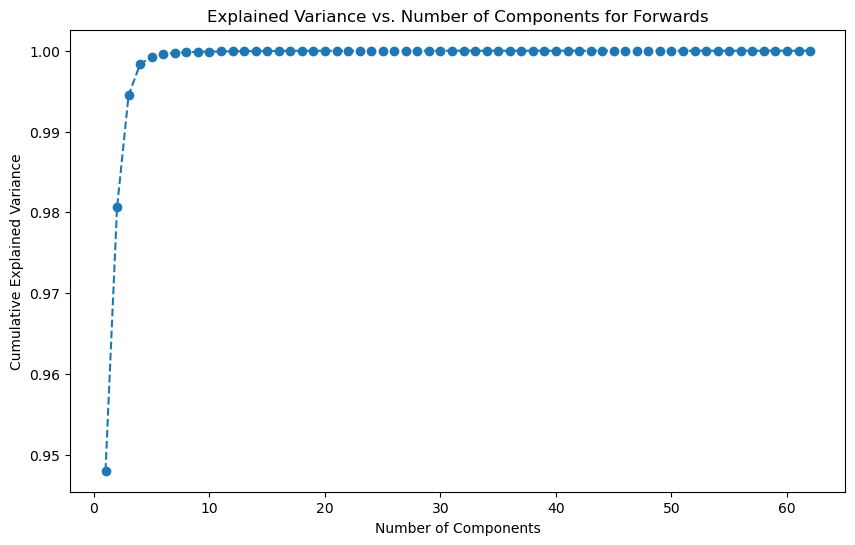

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Forwards')
plt.show()

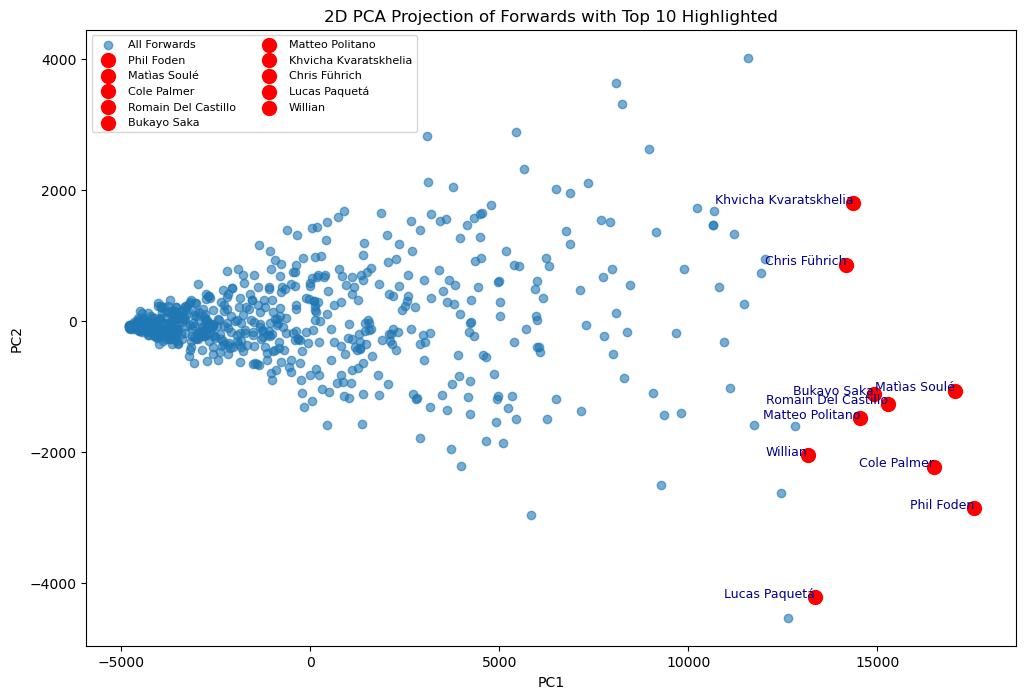

In [145]:
forwards = forwards.loc[forward_nums.index]
forwards['PC1'] = pca_forwards[:, 0]
forwards['PC2'] = pca_forwards[:, 1]

top_forwards = forwards.nlargest(10, 'PC1')


plt.figure(figsize=(12, 8))
plt.scatter(pca_forwards[:, 0], pca_forwards[:, 1], alpha=0.6, label="All Forwards")

for _, row in top_forwards.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Forwards with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

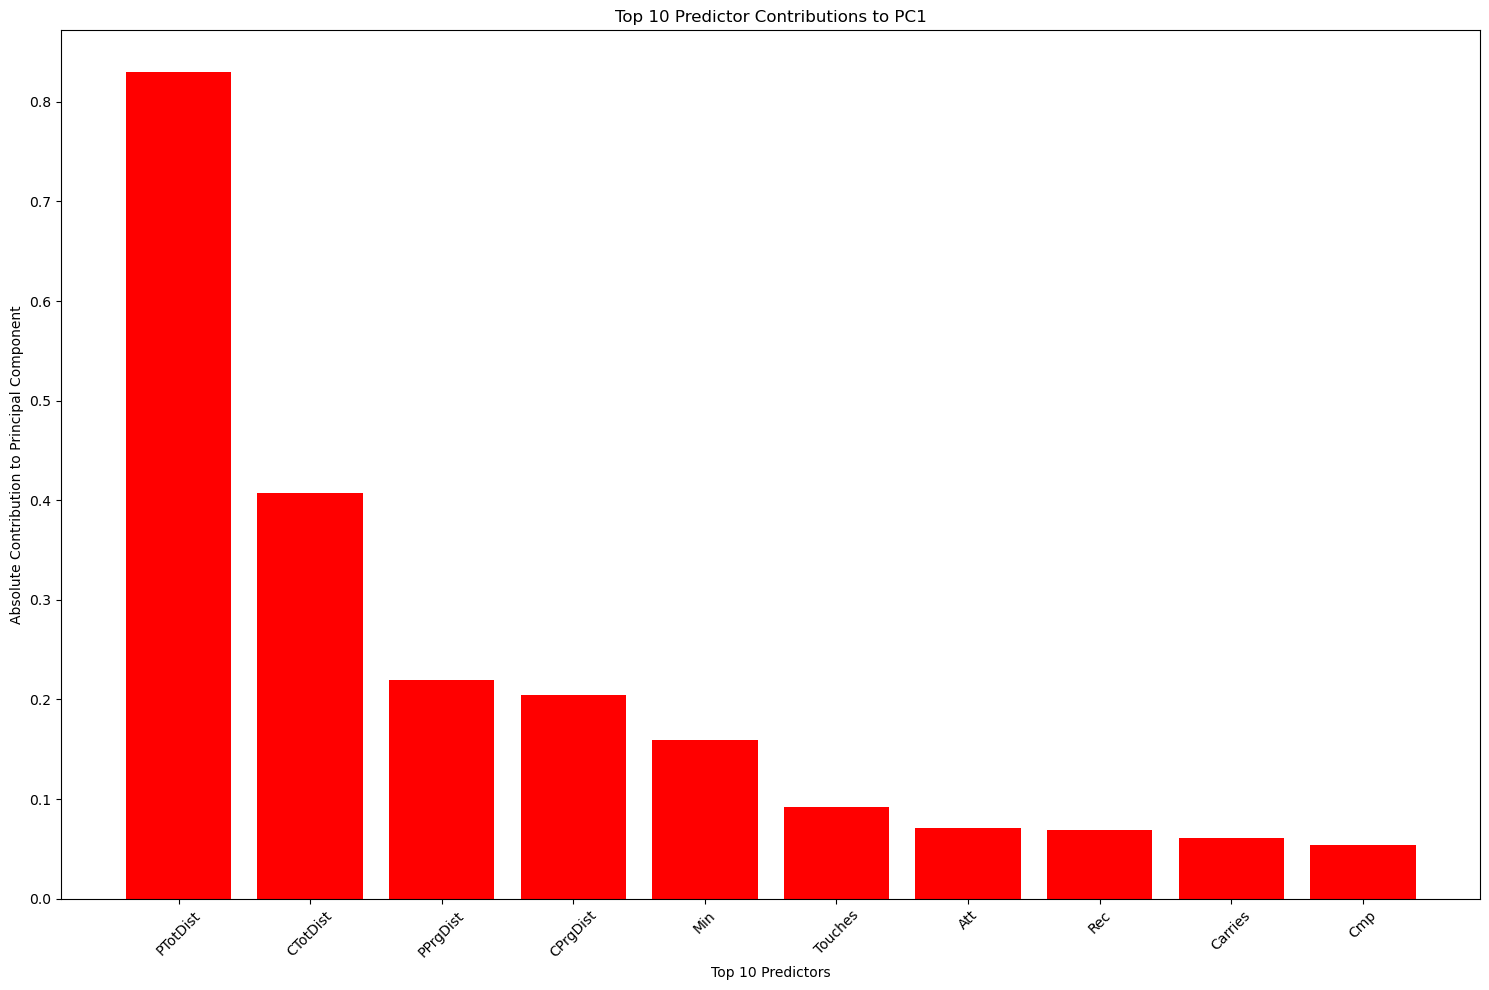

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-10:][::-1]
top_features = forward_nums.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 10 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=45)
ax.set_xlabel('Top 10 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

In [147]:
print("Top 10 forwards based on PC1:")
print(top_forwards[['Player', 'PC1', 'PC2']])

Top 10 forwards based on PC1:
                    Player        PC1       PC2
592             Phil Foden  17556.460 -2854.619
491           Matìas Soulé  17046.611 -1062.756
157            Cole Palmer  16489.153 -2221.788
633    Romain Del Castillo  15292.159 -1264.372
129            Bukayo Saka  14906.945 -1115.814
495        Matteo Politano  14539.244 -1483.661
404  Khvicha Kvaratskhelia  14366.221  1802.031
145          Chris Führich  14171.466   863.357
439          Lucas Paquetá  13350.772 -4218.857
732                Willian  13157.846 -2050.532
